# Color Based Segmentation
The colors in these immunofluorescence images are meaningful - **what if we can use just the colors to segment cells**

## Parameters Required
1. Gaussian Blur Kernel
2. Contour Area Threshold
2. Contour Distance Merging Constant

In [3]:
import os
os.chdir('..')

In [4]:
from utils.data import get_training_data_for_image_set, extract_contour_bounding_box_masked
from utils.visualize import display_instances_segments
import lung_map_utils
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
a = get_training_data_for_image_set('data/image_set_90')
hsv_img = a['2015-04-029_60X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_003.tif']['hsv_img']
sub = extract_contour_bounding_box_masked(
    cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB),
    a['2015-04-029_60X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_003.tif']['regions'][2]['points']
)
sub_hsv = extract_contour_bounding_box_masked(
    hsv_img,
    a['2015-04-029_60X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_003.tif']['regions'][2]['points']
)

## Segmentation Area
*Shown in RGB as well as HSV space.*

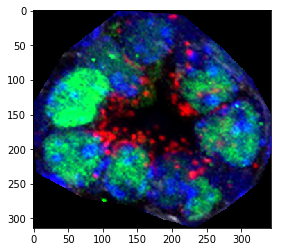

In [5]:
plt.imshow(sub)

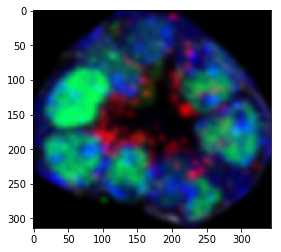

In [6]:
sub_blur = cv2.GaussianBlur(sub, (21,21), 0)
plt.imshow(sub_blur)
sub_blur_hsv = cv2.cvtColor(sub_blur, cv2.COLOR_RGB2HSV)

In [7]:
mask = lung_map_utils.create_mask(
    sub_blur_hsv,
    [
        'green',
    ]
)

In [8]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [6]:
masked_sub = cv2.bitwise_and(sub, sub, mask=mask)

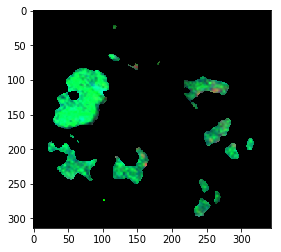

In [7]:
plt.imshow(masked_sub)

> Now that we have successfully extracted green regions, let's generate contours from this.

In [8]:
_, contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print("Found {} contours.".format(str(len(contours))))

Found 18 contours.


> Hmmm, so we have 18 contours for at most 8 cells (using my eyes as a naive segmentation tool). Maybe we can define an area threshold that must be met in order to be considere? Let's go with 250. I do this because I'm defining the minimum a cell can be in a 60x image is 50x50 pixels. **No clue if this is reasonable.**

In [9]:
def contour_area_thresholding(list_of_contours, area_thresh=250):
    results_list = []
    results_dict = []
    for contour in list_of_contours:
        area = cv2.contourArea(contour)
        if area>=area_thresh:
            results_dict.append({'points': contour})
            results_list.append(contour)
    return results_list, results_dict

In [10]:
contours_thresh_list, contours_thresh_dict = contour_area_thresholding(contours)
print("{} contours left after thresholding".format(str(len(contours_thresh_list))))

7 contours left after thresholding


> What do these 8 contours look like?

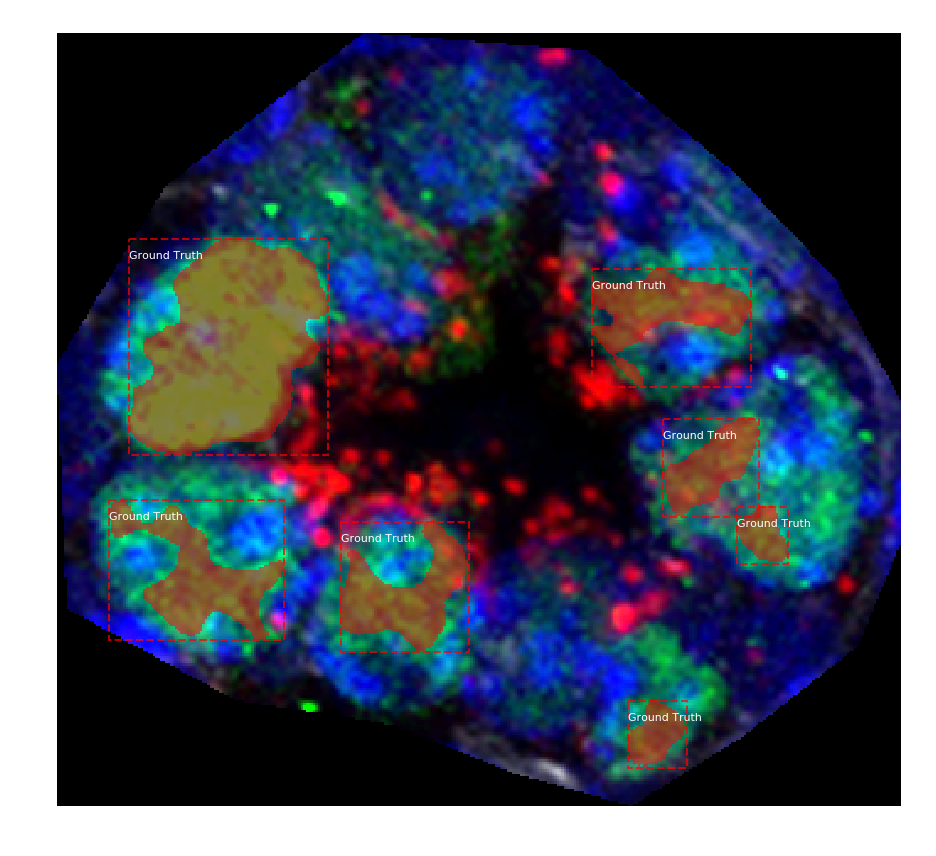

In [11]:
display_instances_segments(
    sub,
    contours_thresh_dict,
    ['raw']
)

> At this point, probably obvious that we want to combine in some way. How about some sort of distance metric? Let's use vector norm and set the threshold at 15 pixels.

## Combining segments based on vector norm

In [12]:
def find_if_close(cnt1,cnt2):
    row1,row2 = cnt1.shape[0],cnt2.shape[0]
    for i in range(row1):
        for j in range(row2):
            dist = np.linalg.norm(cnt1[i]-cnt2[j])
            if abs(dist) < 15 :
                return True
            elif i==row1-1 and j==row2-1:
                return False
            
LENGTH = len(contours_thresh_list)
status = np.zeros((LENGTH,1))

for i,cnt1 in enumerate(contours_thresh_list):
    x = i    
    if i != LENGTH-1:
        for j,cnt2 in enumerate(contours_thresh_list[i+1:]):
            x = x+1
            dist = find_if_close(cnt1,cnt2)
            if dist == True:
                val = min(status[i],status[x])
                status[x] = status[i] = val
            else:
                if status[x]==status[i]:
                    status[x] = i+1

In [13]:
unified = []
maximum = int(status.max())+1
for i in range(maximum):
    pos = np.where(status==i)[0]
    if pos.size != 0:
        cont = np.vstack(contours_thresh_list[i] for i in pos)
        hull = cv2.convexHull(cont)
        unified.append({'points': hull})

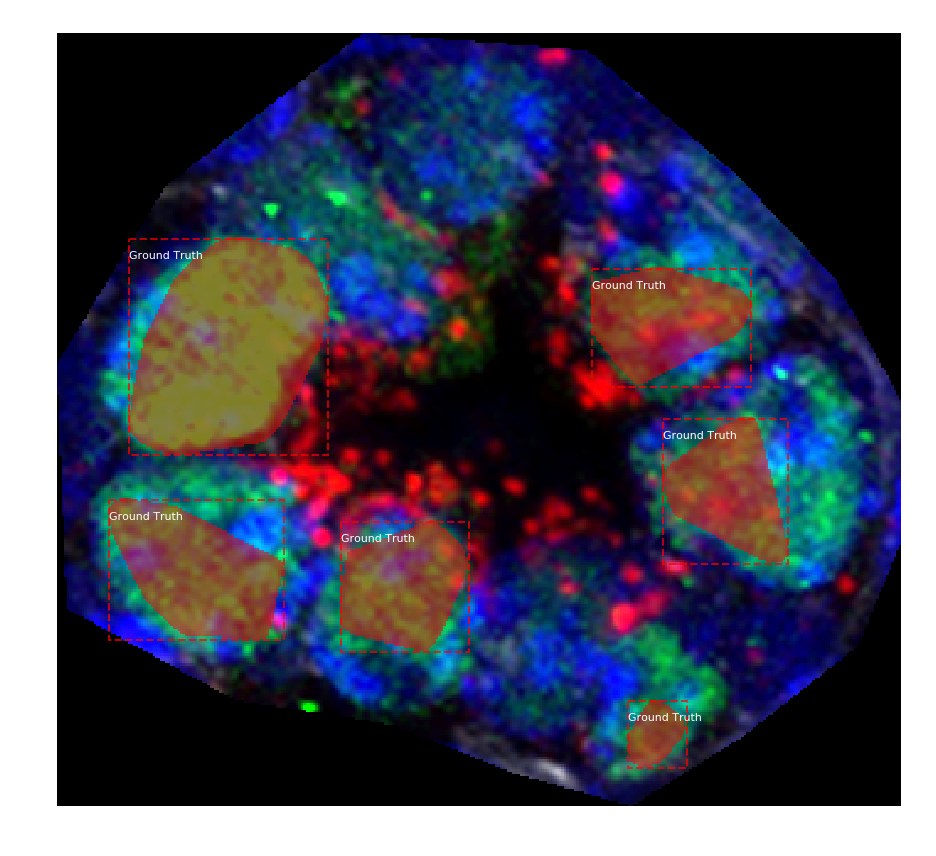

In [14]:
display_instances_segments(
    sub,
    unified,
    ['raw']
)